In [1]:
using Pkg

Pkg.activate("../..")

projectdir_static = dirname(Base.active_project())

projectdirx(args...) = joinpath(projectdir_static, args...)

# Generate functions to access the path of default subdirectories.
for dir_type ∈ ("data", "src","src_analysis", "plots", "scripts", "papers")
    function_name = Symbol(dir_type * "dirx")
    @eval begin
        $function_name(args...) = projectdirx($dir_type, args...)
    end
end

using DrWatson

@quickactivate "GRNEvoContingencyAnalysis"

projectname()

  Activating project at `~/Documents/GRNEvoContingency`


  Activating project at `~/Documents/GRNEvoContingency/notebooks`


"GRNEvoContingencyAnalysis"

In [2]:
using JLD2
using CairoMakie
using ColorSchemes
using BenchmarkTools
using Distances
using StatsPlots
using Clustering
using MultivariateStats
using HypothesisTests
using PyCall
using DecisionTree
using DataFrames
using Combinatorics
using NetworkLayout
using LinearAlgebra
using UMAP
using PyCallJLD2
using Graphs

include(srcdirx("GRNEvoContingency.jl"))
include(srcdirx("Analysis.jl"))

exp_name = "RE_Minimal_Inhibiting_DeNovo"
local_nb_data = "InhibitingData/"

include(srcdirx("ExperimentSetups/DeNovoStripe/" * exp_name * ".jl"))

include(srcdirx("GRNVisualization.jl"))
include(srcdirx("Visualization.jl"))
include(srcdirx("Visualization_SI.jl"))

extract_mut_pred (generic function with 1 method)

In [3]:
xgboost = pyimport("xgboost");

In [4]:
load_trajectory_data = true

load_epistasis_data = true
load_phenotype_data = true

load_shap_data = true

load_inital_deltaF = true

true

In [5]:
save_figs = false

false

# Load Data

In [6]:
all_conv = []
all_geno_traj = []
all_fitness_traj = []
all_min_end_networks = []
all_min_fs_networks = []
all_wait_times = []
all_mut_types = []
all_mut_sizes = []
all_mut_choices = []
all_mat_av_X = []

if load_trajectory_data
    exp_versions = ["N1","N2","N3","N4","N5","N6"]
else
    exp_versions = ["your_trajectory_datasets_here", "some_outputs_of:scripts/RepeatedEvolution_MinDyn.jl"]
end

for ver in exp_versions

    data = load(datadirx("exp_pro/DeNovoStripe/" * exp_name * "_RawData_" * ver * ".jld2"));

    conv = data["converged"]

    push!(all_conv,conv)
    push!(all_geno_traj,data["geno_traj"][conv])
    push!(all_fitness_traj,data["fitness_traj"][conv])
    push!(all_min_end_networks,data["min_end_networks"])
    push!(all_min_fs_networks,data["min_fs_networks"])
    push!(all_wait_times,data["wait_times"][conv])
    push!(all_mut_types,data["mut_type"][conv])
    push!(all_mut_sizes,data["mut_sizes"][conv])
    push!(all_mut_choices,data["mut_choices"][conv])
    push!(all_mat_av_X,data["dmat_X_av"])
end

all_conv = reduce(vcat,all_conv)
all_geno_traj = reduce(vcat,all_geno_traj)
all_fitness_traj = reduce(vcat,all_fitness_traj)
all_min_end_networks = reduce(vcat,all_min_end_networks)
all_min_fs_networks = reduce(vcat,all_min_fs_networks)
all_wait_times = reduce(vcat,all_wait_times)
all_mut_types = reduce(vcat,all_mut_types)
all_mut_sizes = reduce(vcat,all_mut_sizes)
all_mut_choices = reduce(vcat,all_mut_choices)
all_mat_av_X = reduce(hcat,all_mat_av_X);

In [7]:
plot_save_dir = "DeNovoStripe/" * exp_name 
plot_save_dir_supp = "DeNovoStripe/Supplementary/" * exp_name 

save_fig = false

false

# Prepare simulation data for analysis 

Convergence rate:

In [8]:
conv_time = map(x->sum(x),all_wait_times)

nconv = sum(all_conv)

105847

Assign minimal stripe topologies & evaluate basic simulation stats:

In [9]:
fs_mss =  map(list_mss->select_minimal_topologies(list_mss),all_min_fs_networks)
ls_mss =  map(list_mss->select_minimal_topologies(list_mss),all_min_end_networks);

Build trajectory data structure:

In [10]:
trajectories = map(n->Trajectory(n,all_geno_traj[n],all_fitness_traj[n],all_wait_times[n] .+ 1,all_mut_choices[n],all_mut_types[n],all_mut_sizes[n],weight_names),1:nconv);

for (n,tr) in enumerate(trajectories)
    assign_minimal_subgraphs!(tr,fs_mss[n],ls_mss[n])
end

inc_metagraph, vertex_top_map,top_vertex_map,vertex_complexity_map,inclusion_matrix = create_inclusion_metagraph(trajectories);

minimal_motif_id = findall(indegree(inc_metagraph) .== 0);

minimal_motifs = reduce(hcat,[vertex_top_map[vertex_id] for vertex_id in minimal_motif_id])

for tr in trajectories
    assign_inc_vertex_ids!(tr,top_vertex_map)
    assign_inc_parents!(tr,inclusion_matrix,vertex_complexity_map,minimal_motif_id)
end

Evaluate/assign dependency evaluation combinatorial data:

In [11]:
fitness_eps = 1e-2 # epsilon for netural fitness evaluation

if load_epistasis_data
    epi_types_full = load(local_nb_data * "epistasis_types_full_deltas_N6.jld2","data")

    for (tr,epi_type) in zip(trajectories,epi_types_full)
        tr.epistasis = epi_type
    end
else
    for tr in trajectories
        evaluate_epistasis_types_full_deltas!(tr,grn_parameters,DefaultGRNSolver(),fitness_function,mutation_op)
    end
end

# MST Distribution & Dynamics

Identify MST distribution and summary stats:

In [12]:
end_parents = map(tr->tr.inc_metagraph_vertices[end],trajectories)

sorted_uep,sorted_counts_uep = return_order_by_count(end_parents);

uep_position_dict = Dict(v=>n for (n,v) in enumerate(sorted_uep));

mst_conf_int = confint(MultinomialLRT(sorted_counts_uep),0.05)

sorted_uep_other = vcat(sorted_counts_uep[1:8],[sum(sorted_counts_uep[9:end])])

mst_conf_int_r = confint(MultinomialLRT(sorted_uep_other),0.05)

top_n = 8

top_8_mst = map(x-> x ∈ sorted_uep[1:8], end_parents);

print("Total unique MST: " * string(length(sorted_uep)))

Total unique MST: 732

Compute MST UMAP embedding:

In [13]:
embedding = umap(all_mat_av_X[:,top_8_mst], 2; metric = d_metric,n_neighbors = 40,min_dist = 0.5);

Produce Figure 2 - "The distribution of adaptive outcomes relating to the core mechanisms of stripe formation"

Compute nearest hamming for MST match

In [23]:
n = 8

is_other = findall(map(tr->!(tr.inc_metagraph_vertices[end] ∈ sorted_uep[1:n]),trajectories));

is_other_h0 = findall(map(tr->!(tr.inc_metagraph_vertices[end] ∈ sorted_uep[1:n]) & (tr.inc_metagraph_vertices[tr.H0] ∈ sorted_uep[1:n]),trajectories));

other_mst = reduce(hcat,[tr.minimal_stripe_subgraphs[end] for tr in trajectories[is_other]]);

mst8 = reduce(hcat,[vertex_top_map[i] for i in sorted_uep[1:n]])

mst8_other = pairwise(Hamming(),mst8,other_mst,dims = 2);

hamming_match = [argmin(v) for v in eachcol(mst8_other)];

hamming_distances = countmap([(minimum(v),n) for (v,n) in zip(eachcol(mst8_other),[i ∈ is_other_h0 for i in is_other])]);

end_parent_pos = [uep_position_dict[i] > n ? 0 : uep_position_dict[i] for i in end_parents]

end_parent_pos[is_other] .= hamming_match;

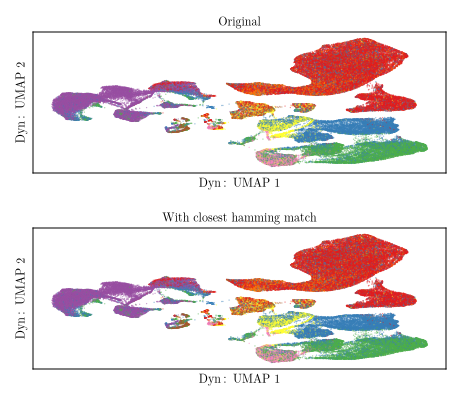

In [24]:
fig = Figure(resolution = (462,400),fontsize = fontsize_pub)

ds_config_12 = dynamical_summary_config(fontsize_pub,2.,ext_palette,node_colors,draw_config_12,1.5,12.,2.,1.,2.5,14.)

# embedding = umap(all_mat_av_X, 2; metric = d_metric,n_neighbors = 50,min_dist = 0.5);

plot_closest_hamming_match!(fig,trajectories,top_n,sorted_uep,vertex_top_map,embedding,ds_config_12)

fig

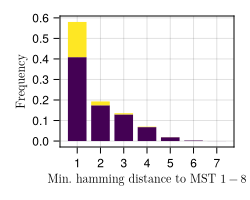

In [25]:
fig = Figure(resolution = (250,200),fontsize = fontsize_pub)

plot_hamming_distances!(fig,trajectories,top_n,sorted_uep,vertex_top_map,ds_config_12)

fig

Distribution of MST complexities

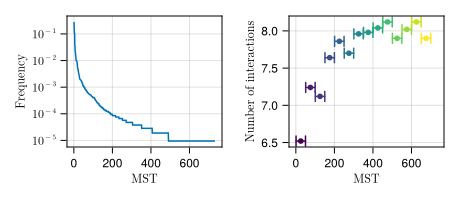

In [26]:
av_network_length = [mean(map(gt->sum(gt.!= 0),map(tr->tr.geno_traj[end],filter(tr->tr.inc_metagraph_vertices[end] == n,trajectories)))) for n in sorted_uep];

length_mst = map(x->sum(vertex_top_map[x] .!= 0),sorted_uep);

fig = Figure(resolution = (460,200),fontsize = fontsize_pub)
ax1 = Axis(fig[1,1], ylabel = L"\text{Frequency}", xlabel = L"\text{MST}")
ax2 = Axis(fig[1,2], ylabel = L"\text{Number of interactions}", xlabel = L"\text{MST}")

lines!(ax1,log10.(sorted_counts_uep ./ sum(sorted_counts_uep)))

n_gap = 50

n_max = Int(floor(length(sorted_uep)/n_gap)) - 1

x_low = [n_gap*n + 1 for n in 0:n_max]
x_high = [n_gap*(n + 1) for n in 0:n_max]
vals_mst = [mean(length_mst[n_gap*n + 1:n_gap*(n+1)]) for n in 0:n_max]
vals_gt = [mean(av_network_length[n_gap*n + 1:n_gap*(n+1)]) for n in 0:n_max]

rangebars!(ax2,vals_mst, x_low, x_high, color = LinRange(0, 1, length(vals_mst)),
    whiskerwidth = 10, direction = :x)

CairoMakie.scatter!(ax2,((x_low .+ x_high) ./ 2), vals_mst,color = LinRange(0, 1, length(vals_mst)),markersize = 8.)

CairoMakie.linkxaxes!(ax1,ax2)

ax1.yticks = ([-1,-2,-3,-4,-5],[L"10^{-1}",L"10^{-2}",L"10^{-3}",L"10^{-4}",L"10^{-5}"])

fig

Weight change identities throughout evolution 

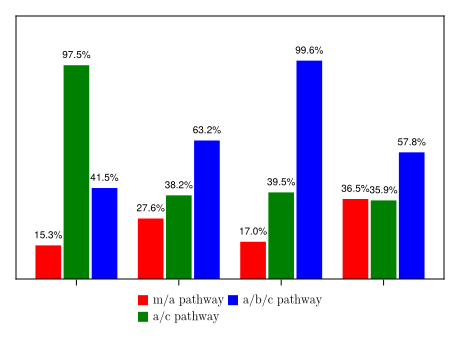

In [28]:
morph_loop = findall(x->x ∈ ["M=>A","A=>A"],weight_names)
ac_loop = findall(x->x ∈ ["A=>C","C=>A","C=>C"],weight_names)
abc_loop = findall(x->x ∈ ["A=>B","B=>A","B=>B","B=>C","C=>B"],weight_names);

weight_names_abc = [2,4,5,6,8]
weight_names_ma = [1,10]
weight_names_ac = [3,7,9]

all_weight_name_loop = vcat(vcat(weight_names_abc,weight_names_ac),weight_names_ma)

weight_loop_dict = Dict()

for i in morph_loop
    weight_loop_dict[i] = :morph_loop
end

for i in ac_loop
    weight_loop_dict[i] = :ac_loop
end

for i in abc_loop
    weight_loop_dict[i] = :abc_loop
end

fig = Figure(resolution = (460,Int(floor(750/2)) - 3*12),fontsize = fontsize_pub)

evo_config_12 = evo_summary_config(fontsize_pub,6.,1.,ext_palette,node_colors,draw_config_12,1.,4.,2.,epi_colors,0.5)

identify_loop_mutations!(fig,trajectories,evo_config_12,weight_loop_dict)

fig

Compute epistasis types

In [29]:
all_2mut_epi_char = [[],[]]

all_neutral_corr = []
all_ne_corr = []
all_me_corr = []
all_se_corr = []
all_rse_corr = [] 

me_ex = []
rse_ex = []
se_ex = []
ne_ex = []

me_ex = []

small_lim = 1e-2

k_choice = 3

min_n = length(exp_versions)*300

for k in 1:length(sorted_uep)
    mech1_traj = filter(tr->tr.inc_metagraph_vertices[end] == sorted_uep[k],trajectories);
    lmst = length(mech1_traj)

    if lmst > min_n

        mech1_traj = filter(tr->tr.inc_metagraph_vertices[end] == sorted_uep[k],trajectories);

        mech1_mst = map(tr->tr.minimal_stripe_subgraphs[end],mech1_traj)[1];
        
        mech1_mst_id = findall(x->x!=0,mech1_mst);

        mech1_en = reduce(hcat,reduce(vcat,map(tr->[f .- l for (f,l) in zip(tr.geno_traj[2:end], tr.geno_traj[1:end-1])],mech1_traj)))

        epi_counts_lS0 = map(tr->tr.epistasis[1:tr.H0-2],mech1_traj);

        mut_info_lS0 = map(tr->[m.weight_id for m in tr.mutant_info[1:tr.H0-2]],mech1_traj);

        epi_counts_hS0 = map(tr->tr.epistasis[tr.H0-1:end],mech1_traj);

        mut_info_hS0 = map(tr->[m.weight_id for m in tr.mutant_info[tr.H0-1:end]],mech1_traj);

        for (n,(e_data,m_data)) in enumerate(zip([epi_counts_lS0,epi_counts_hS0],[mut_info_lS0,mut_info_hS0]))
        
            epi_info_ = [[(m,e) for (m,e) in zip(mv,ev)] for (mv,ev) in zip(m_data,e_data)];
            
            epi_info_2mut = filter(x->length(x) > 0, map(ei->filter(x->length(x[2]) == 4,ei),epi_info_));

            epi_char_2mut = map(ei->[(characterise_weight_int(wi,mech1_mst_id),type_epi(e[1],e[2],e[3],e[4],fitness_eps)) for (wi,e) in ei],epi_info_2mut);

            push!(all_2mut_epi_char[n],reduce(vcat,epi_char_2mut));
        end

        #########

        epi_types_raw = reduce(vcat,map(tr->tr.epistasis,mech1_traj))

        @assert length(epi_types_raw) == size(mech1_en,2)

        weight2_id = findall(x->length(x) == 4, epi_types_raw)

        weight2_epi_types = map(e->type_epi(e[1],e[2],e[3],e[4],fitness_eps),epi_types_raw[weight2_id])

        mech1_en_2weight = mech1_en[:,weight2_id]

        for i in 1:10
            for j in 1:10

                if i > j 

                    wi = mech1_en_2weight[i,weight2_epi_types .== :Neutral]
                    wj = mech1_en_2weight[j,weight2_epi_types .== :Neutral]

                    id = [!any(abs.(n) .<= small_lim) for n in zip(wi, wj)]

                    if sum(id) > 50
                        push!(all_neutral_corr,corspearman(wi[id],wj[id]))

                        if k == k_choice
                            push!(neutral_ex,(wi[id],wj[id],i,j))
                        end
                    end

                end
            end
        end

        for i in 1:10
            for j in 1:10
                if i > j 
                    wi = mech1_en_2weight[i,weight2_epi_types .== :ne]
                    wj = mech1_en_2weight[j,weight2_epi_types .== :ne]

                    # id = [!any(n .== 0) for n in zip(wi, wj)]
                    id = [!any(abs.(n) .<= small_lim) for n in zip(wi, wj)]

                    if sum(id) > 50
                        push!(all_ne_corr,corspearman(wi[id],wj[id]))

                        if k == k_choice
                            push!(ne_ex,(wi[id],wj[id],i,j))
                        end

                    end

                end
            end
        end

        for i in 1:10
            for j in 1:10

                if i > j 
                    wi = mech1_en_2weight[i,weight2_epi_types .== :me]
                    wj = mech1_en_2weight[j,weight2_epi_types .== :me]

                    # id = [!any(n .== 0) for n in zip(wi, wj)]
                    id = [!any(abs.(n) .<= small_lim) for n in zip(wi, wj)]

                    if sum(id) > 50
                        push!(all_me_corr,corspearman(wi[id],wj[id]))

                        if k == k_choice
                            push!(me_ex,(wi[id],wj[id],i,j))
                        end
                    end

                end
            end
        end

        for i in 1:10
            for j in 1:10

                if i > j
                    wi = mech1_en_2weight[i,weight2_epi_types .== :se]
                    wj = mech1_en_2weight[j,weight2_epi_types .== :se]

                    # id = [!any(n .== 0) for n in zip(wi, wj)]
                    id = [!any(abs.(n) .<= small_lim) for n in zip(wi, wj)]

                    if sum(id) > 50
                        push!(all_se_corr,corspearman(wi[id],wj[id]))
                        if k == k_choice
                            push!(se_ex,(wi[id],wj[id],i,j))
                        end
                    end

                end
            end
        end

        for i in 1:10
            for j in 1:10

                if i > j
                    wi = mech1_en_2weight[i,weight2_epi_types .== :rse]
                    wj = mech1_en_2weight[j,weight2_epi_types .== :rse]

                    id = [!any(abs.(n) .<= small_lim) for n in zip(wi, wj)]

                    if sum(id) > 50
                        push!(all_rse_corr,corspearman(wi[id],wj[id]))

                        if k == k_choice
                            push!(rse_ex,(wi[id],wj[id],i,j))
                        end
                    end
                end
            end
        end
        
    end
end

for n in [1,2]
    all_2mut_epi_char[n] = reduce(vcat,all_2mut_epi_char[n])
end

all_neutral_corr = filter(x->x ∉ [0,1],all_neutral_corr)
all_ne_corr = filter(x->x ∉ [0,1],all_ne_corr)
all_me_corr = filter(x->x ∉ [0,1],all_me_corr)
all_se_corr = filter(x->x ∉ [0,1],all_se_corr)
all_rse_corr = filter(x->x ∉ [0,1],all_rse_corr);


##########################


ls0_mst_corr = []
ls0_non_mst_corr = []
ls0_inter_mst_corr = []

hs0_mst_corr = []
hs0_non_mst_corr = []
hs0_inter_mst_corr = []

for k in 1:length(sorted_uep)
    mech1_traj = filter(tr->tr.inc_metagraph_vertices[end] == sorted_uep[k],trajectories);
    lmst = length(mech1_traj)

    if lmst > min_n

        mech1_mst = map(tr->tr.minimal_stripe_subgraphs[end],mech1_traj)[1];
        mech1_mst_id = findall(x->x!=0,mech1_mst);

        n_mech1_mst_id = [i for i in 1:10 if i ∉ mech1_mst_id ]

        mech1_en_lS0 = reduce(hcat,reduce(vcat,map(tr->[f .- l for (f,l) in zip(tr.geno_traj[2:tr.H0-1], tr.geno_traj[1:tr.H0-2])],mech1_traj)))

        mech1_en_hS0 = reduce(hcat,reduce(vcat,map(tr->[f .- l for (f,l) in zip(tr.geno_traj[tr.H0+1:end], tr.geno_traj[tr.H0:end-1])],mech1_traj)))

        for (ni,i) in enumerate(mech1_mst_id) 
            for (nj,j) in enumerate(mech1_mst_id) 
                if ni > nj
                    id_lS0 = [!any(n .== 0) for n in zip(mech1_en_lS0[i,:],mech1_en_lS0[j,:])]
                    id_hS0 = [!any(n .== 0) for n in zip(mech1_en_hS0[i,:],mech1_en_hS0[j,:])]

                    if sum(id_lS0) > 100
                        push!(ls0_mst_corr,corspearman(mech1_en_lS0[i,id_lS0],mech1_en_lS0[j,id_lS0]))
                    end

                    if sum(id_hS0) > 100
                        push!(hs0_mst_corr,corspearman(mech1_en_hS0[i,id_hS0],mech1_en_hS0[j,id_hS0]))
                    end
                end
            end
        end

        for (ni,i) in enumerate(n_mech1_mst_id) 
            for (nj,j) in enumerate(n_mech1_mst_id) 
                if ni > nj
                    id_lS0 = [!any(n .== 0) for n in zip(mech1_en_lS0[i,:],mech1_en_lS0[j,:])]
                    id_hS0 = [!any(n .== 0) for n in zip(mech1_en_hS0[i,:],mech1_en_hS0[j,:])]

                    if sum(id_lS0) > 100
                        push!(ls0_non_mst_corr,corspearman(mech1_en_lS0[i,id_lS0],mech1_en_lS0[j,id_lS0]))
                    end

                    if sum(id_hS0) > 100
                        push!(hs0_non_mst_corr,corspearman(mech1_en_hS0[i,id_hS0],mech1_en_hS0[j,id_hS0]))
                    end
                end
            end
        end

        for (ni,i) in enumerate(mech1_mst_id) 
            for (nj,j) in enumerate(n_mech1_mst_id) 
                if ni > nj
                    id_lS0 = [!any(n .== 0) for n in zip(mech1_en_lS0[i,:],mech1_en_lS0[j,:])]
                    id_hS0 = [!any(n .== 0) for n in zip(mech1_en_hS0[i,:],mech1_en_hS0[j,:])]

                    if sum(id_lS0) > 100
                        push!(ls0_inter_mst_corr,corspearman(mech1_en_lS0[i,id_lS0],mech1_en_lS0[j,id_lS0]))
                    end

                    if sum(id_hS0) > 100
                        push!(hs0_inter_mst_corr,corspearman(mech1_en_hS0[i,id_hS0],mech1_en_hS0[j,id_hS0]))
                    end
                end
            end
        end

    end
end

In [30]:
s0_mutants = map(tr->tr.mutant_info[tr.H0-1].weight_id,trajectories);
s0_mutants_type = map(tr->tr.mutant_info[tr.H0-1].mut_type,trajectories);

s0_mt = [zip(m,first.(t)) |> collect for (m,t) in zip(s0_mutants,s0_mutants_type)]  # (weight,id,new/existing)

s0_2weight_mut = findall(x->length(x) == 2,s0_mt)

s0_epistasis = map(tr->tr.epistasis[tr.H0-1],trajectories);

s0_epi_types = map(e->(type_epi(e[1],e[2],e[3],e[4],fitness_eps),e),s0_epistasis[s0_2weight_mut])

s0_mt_2w = s0_mt[s0_2weight_mut]


################

s0_mutant_background = map(tr->sign.(tr.mutant_info[tr.H0-1].start_network),trajectories);

s0_mutant_background_2w = s0_mutant_background[s0_2weight_mut];

s0_mutant_background_2w_eo = map(x-> x.!= 0,s0_mutant_background_2w);

In [31]:
s0_mt_2w_ordered = return_order_by_count(s0_mt_2w)

s0_top_change = [edit_sn(w) for w in s0_mt_2w_ordered[1]];

# output as .pdfs network organization of top 8 S0 mutants 

for i in 1:8
    fig = CairoMakie.Figure(resolution = (100,100), fontsize = 10.)
    ax = Axis(fig[1,1],aspect = DataAspect())

    draw_grn_mutant_ab!(ax,s0_top_change[i][2],s0_top_change[i][1],ds_config_12.draw_config,fs12_default,ds_config_12.node_colors,ds_config_12.fontsize,:red,false,false)

    cond_save(plotsdirx(plot_save_dir_supp,"G1Mutant_Epi/GM" * string(i) * ".pdf"),fig,save_figs)

    fig

end

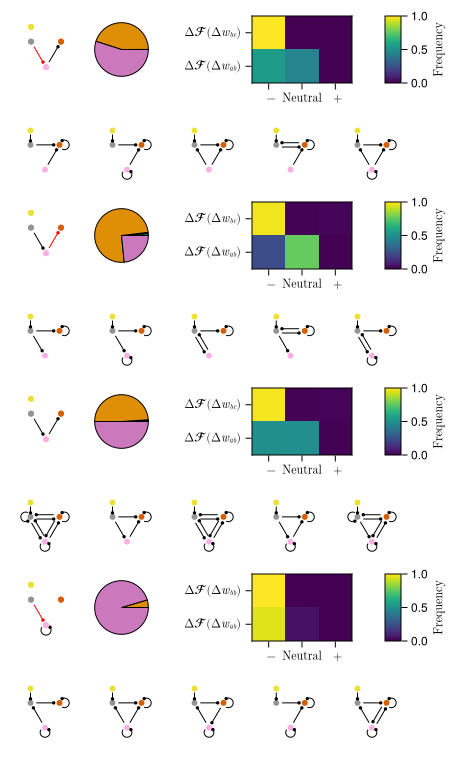

In [33]:
fig_m =  Figure(resolution = (460,760),fontsize = 12)

weight_names_df_latex= [L"$\Delta \mathcal{F}(\Delta w_{aa})$"
L"$\Delta \mathcal{F}(\Delta w_{ab})$"
L"$\Delta \mathcal{F}(\Delta w_{ac})$"
L"$\Delta \mathcal{F}(\Delta w_{ba})$"
L"$\Delta \mathcal{F}(\Delta w_{bb})$"
L"$\Delta \mathcal{F}(\Delta w_{bc})$"
L"$\Delta \mathcal{F}(\Delta w_{ca})$"
L"$\Delta \mathcal{F}(\Delta w_{cb})$"
L"$\Delta \mathcal{F}(\Delta w_{cc})$"
L"$\Delta \mathcal{F}(\Delta w_{ma})$"]

for (n,i) in enumerate([2,3,5,6])
    fig = fig_m[2*n - 1,1] = GridLayout()
    fig_g = fig_m[2*n,1] = GridLayout()

    mutant_id = s0_mt_2w_ordered[1][i]

    top_mutant_backround = return_order_by_count(s0_mutant_background_2w_eo[findall(x-> x== mutant_id ,s0_mt_2w)])

    for (n,m) in enumerate(top_mutant_backround[1][1:5])
        ax = Axis(fig_g[1,n],aspect = DataAspect())
        draw_grn_ab!(ax,m,ds_config_12.draw_config,ds_config_12.node_colors,ds_config_12.fontsize,false,false)
    end
        
    ax = Axis(fig[1,1],aspect = DataAspect())

    draw_grn_mutant_ab!(ax,s0_top_change[i][2],s0_top_change[i][1],ds_config_12.draw_config,fs12_default,ds_config_12.node_colors,ds_config_12.fontsize,:red,false,false)

    weight_id_1 = mutant_id[1][1]
    weight_id_2 = mutant_id[2][1]

    epi_info = s0_epi_types[findall(x-> x== mutant_id ,s0_mt_2w)]
        
    weight_id_1_df = map(x->x[3],last.(epi_info))
    weight_id_2_df = map(x->x[2],last.(epi_info))

    epi_types = [:Neutral,:ne,:me,:se,:rse]
        
    c = countmap(first.(epi_info))

    epi_prop = [haskey(c,p) ? c[p]/length(epi_info) : 0. for p in epi_types]

    ax = Axis(fig[1,2],aspect = DataAspect())

    CairoMakie.pie!(ax,epi_prop,color = [top_n_colors[1],top_n_colors[3],top_n_colors[end],top_n_colors[2],top_n_colors[4]])

    hidexdecorations!(ax)
    hideydecorations!(ax)
    hidespines!(ax)

    w1d = count(weight_id_1_df .< -fitness_eps) / length(weight_id_1_df)

    w1n = count(abs.(weight_id_1_df) .<= fitness_eps) / length(weight_id_1_df)

    w1a = count(weight_id_1_df .> fitness_eps) / length(weight_id_1_df)

    w2d = count(weight_id_2_df .< -fitness_eps) / length(weight_id_2_df)

    w2n = count(abs.(weight_id_2_df) .<= fitness_eps) / length(weight_id_2_df)

    w2a = count(weight_id_2_df .> fitness_eps) / length(weight_id_2_df)

    hmd = [w1d w1n w1a ; w2d w2n w2a] |> transpose

    ax1 = Axis(fig[1,3:4],aspect = DataAspect())

    hm = CairoMakie.heatmap!(ax1,hmd,colorrange = (0.,1.))

    Colorbar(fig[1,5], hm,label = L"\text{Frequency}",labelrotation = pi/2)

    ax1.yticks = (1:2,[weight_names_df_latex[weight_id_1],weight_names_df_latex[weight_id_2]])
    ax1.xticks = (1:3,[L"-" ,L"\text{Neutral}",L"+" ])

    colgap!(fig,Relative(0.05))
    rowgap!(fig,Relative(0.05))
end

rowgap!(fig_m.layout,Relative(0.025))

cond_save(plotsdirx(plot_save_dir_supp,"Epistasis_decomp_S0_mutants_2356.pdf"),fig_m,save_figs)

fig_m

Initial mutation neutrality analysis

In [40]:
if load_inital_deltaF

    DeltaF = load(local_nb_data * "DeltaFN=1.jld2")["Data"]

else
    DeltaF = []

    founder_fitness = fitness_function(founder.phenotype)

    for n_weight in 1:5

        print(n_weight)

        n_sample_func() = n_weight

        mutation_op = MutationOperatorDual(mult_noise_distribution,additive_noise_distribution,n_sample_func,pm_prob,min_affinity,max_w,mutation_weights,sign_flip_probability);

        mutate_function = i -> noise_mtype_mult_add(i,mutation_op)

        DeltaF_X = []

        for _ in 1:1e6

            mutant,m_choices,m_type,m_sizes,m_valid = create_mutant(founder,mutate_function,development)
            
            if m_valid && SciMLBase.successful_retcode(mutant.phenotype.retcode)

                mutant_fitness = fitness_function(mutant.phenotype)

                ΔF1 = mutant_fitness[1] - founder_fitness[1]
                ΔF2 = mutant_fitness[2] - founder_fitness[2]

                ΔF = ΔF1 != 0 ? ΔF1 : ΔF2

                push!(DeltaF_X,ΔF)
            else
                push!(DeltaF_X,-Inf)
            end
            
        end

        push!(DeltaF,DeltaF_X)
    end

    save(local_nb_data * "DeltaFN=1.jld2","Data",DeltaF);
end


fix_prob_n1iii = [[Δf != -Inf ? fixation_probability_kim(Δf,β[1],β[2]) : 0. for Δf in x] for x in DeltaF];
fix_prob_n1ii = [[Δf != -Inf ? fixation_probability_kim(Δf,β[1],1000) : 0. for Δf in x] for x in DeltaF];
fix_prob_n1i = [[Δf != -Inf ? fixation_probability_kim(Δf,β[1],100) : 0. for Δf in x] for x in DeltaF];

mean_DF = [count(x->abs(x) <  1e-10,x[x.!=-Inf])/sum(x.!=-Inf) for x in DeltaF];

epi_ratio_1 = map(tr->extract_minimal_weights_with_fitness(tr.epistasis[1][2],fitness_eps),filter(tr->(tr.H0 > 2),trajectories));
epi_counts_1 = reduce(vcat,map(tr->tr.epistasis[1][1],filter(tr->(tr.H0 > 2),trajectories)));
mut_n_counts_1 = reduce(vcat,map(tr->get_mut_n(tr,1,1),filter(tr->(tr.H0 > 2),trajectories)));

epi_mutn_counts_1 = countmap(mut_n_counts_1)
total_epi_mutn_1 = sum(values(epi_mutn_counts_1))
epi_mutn_prop_1 = Dict(key=>value/total_epi_mutn_1 for (key,value) in epi_mutn_counts_1)

epi_mutn_prob_1 = [epi_mutn_prop_1[i] for i in 1:4];

4-element Vector{Float64}:
 0.4283774803000095
 0.38233171935820753
 0.15002373492832052
 0.03379853792841546

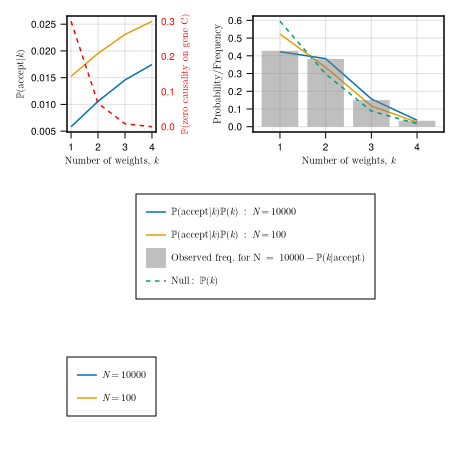

In [41]:
fig = Figure(resolution = (460,460),fontsize = 10.)

fn(k) = prod([(3-n)/(10-n) for n in 0:k-1])

ax = Axis(fig[1,1], xlabel = L"\text{Number of weights, }k", ylabel = L"\mathbb{P}(\text{accept} | k)")
ax0 = Axis(fig[1,1], yaxisposition = :right,yticklabelcolor  = :red,ylabelcolor  = :red,ylabel = L"\mathbb{P}(\text{zero causality on gene C})")

hidexdecorations!(ax0)
hideydecorations!(ax0,label = false, ticklabels = false)

ax1 = Axis(fig[1,2], xlabel = L"\text{Number of weights, }k", ylabel = L"\text{Probability/Frequency}")
ax2 = Axis(fig[1,2], ylabel = L"\mathbb{E}(\Delta F)",yaxisposition = :right)

hidexdecorations!(ax2)
hideydecorations!(ax2)

mean_prob_n1iii = [mean(x) for x in fix_prob_n1iii[1:4]]
mean_prob_n1ii = [mean(x) for x in fix_prob_n1ii[1:4]]
mean_prob_n1i = [mean(x) for x in fix_prob_n1i[1:4]]

CairoMakie.lines!(ax,mean_prob_n1iii, label = L"N = 10000")
CairoMakie.lines!(ax,mean_prob_n1i, label = L"N = 100")

CairoMakie.lines!(ax0,[fn(k) for k in 1:4], linestyle = :dash, color = :red)

null_prob_n1 = [prob_k_mutations(k,mut_prob,10) for k in 1:4];

CairoMakie.lines!(ax1,mean_prob_n1iii .* null_prob_n1 ./ sum(mean_prob_n1iii .* null_prob_n1), label = L"\mathbb{P}(\text{accept} | k)\mathbb{P}(k) \text{ : } N = 10000")
CairoMakie.lines!(ax1,mean_prob_n1i .* null_prob_n1 ./ sum(mean_prob_n1i .* null_prob_n1), label = L"\mathbb{P}(\text{accept} | k)\mathbb{P}(k) \text{ : } N = 100")

CairoMakie.barplot!(ax1,epi_mutn_prob_1, label = L"\text{Observed freq. for N = 10000} - \mathbb{P}(k | \text{accept})", color = (:grey,0.5))

CairoMakie.lines!(ax1,null_prob_n1, linestyle = :dash, label = L"\text{Null: } \mathbb{P}(k)")

fig[3,1] = Legend(fig,ax)

fig[2,1:2] = Legend(fig,ax1)

cond_save(plotsdirx(plot_save_dir_supp,"FigSX-NeutralMinimaility.pdf"),fig,save_figs)

fig

Predictability analysis

In [42]:
top_n = 4

predict_id = sorted_uep[1:top_n]

label_names = 1:top_n |> collect

trajectories_p = copy(trajectories)

vertex_to_predict_label = Dict(vertex=>n for (n,vertex) in enumerate(predict_id))
predict_label_to_vertex = Dict(n=>vertex for (n,vertex) in enumerate(predict_id))
predict_label_to_vertex[top_n+1] = -1
labels = map(tr->tr.inc_metagraph_vertices[tr.H0] ∈ predict_id ? vertex_to_predict_label[tr.inc_metagraph_vertices[tr.H0]] : top_n + 1,trajectories_p);

const c_types = ["c" for _ in 1:10];

const predict_colors = vcat(ext_palette[1:top_n],[:grey]);

null_H0_dist = [count(x->x==i,labels) for i in 1:top_n+1] ./ length(trajectories_p);


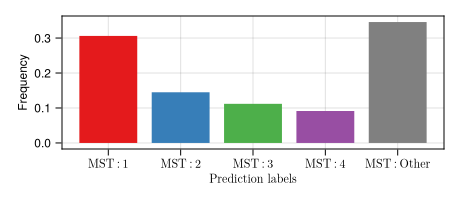

In [45]:
fig = Figure(resolution = (460,200),fontsize = fontsize_pub)

ax = Axis(fig[1,1],xlabel = L"\text{Prediction labels}", ylabel =  "Frequency")

CairoMakie.barplot!(ax,[1,2,3,4,5],null_H0_dist, color = predict_colors[1:5])

ax.xticks = (1:5,[L"\text{MST:1}",L"\text{MST:2}",L"\text{MST:3}",L"\text{MST:4}",L"\text{MST:Other}"])

cond_save(plotsdirx(plot_save_dir_supp,"NullH0Dist.pdf"),fig,save_fig)

fig

In [46]:
ac = "DN" * string(top_n)

"DN4"

In [47]:
train_id = load(local_nb_data * "train_test_ids_Other_" * ac * ".jld2", "train")
test_id = load(local_nb_data * "train_test_ids_Other_" * ac * ".jld2", "test");

In [48]:
X_train_ttl_v = [reduce(hcat,unique([vcat(features,label) for features in tr.topologies[1:tr.H0-1]])) for (label,tr) in zip(labels[train_id],trajectories_p[train_id])]
X_train_ttl = reduce(hcat,X_train_ttl_v) |> transpose |> collect

y_train_ttl = copy(Int.(X_train_ttl[:,13]))

X_train_gtl_v = [reduce(hcat,[vcat(features,label) for features in tr.geno_traj[1:tr.H0-1]]) for (label,tr) in zip(labels[train_id],trajectories_p[train_id])]
X_train_gtl  = reduce(hcat,X_train_gtl_v) |> transpose |> collect;

y_train_gtl = copy(Int.(X_train_gtl[:,13]))

###################

X_test_ttl_v = [reduce(hcat,unique([vcat(features,label) for features in tr.topologies[1:tr.H0-1]])) for (label,tr) in zip(labels[test_id],trajectories_p[test_id])]
X_test_ttl = reduce(hcat,X_test_ttl_v) |> transpose |> collect

y_test_ttl = copy(Int.(X_test_ttl[:,13]))

X_test_gtl_v = [reduce(hcat,[vcat(features,label) for features in tr.geno_traj[1:tr.H0-1]]) for (label,tr) in zip(labels[test_id],trajectories_p[test_id])]
X_test_gtl  = reduce(hcat,X_test_gtl_v) |> transpose |> collect;

y_test_gtl = copy(Int.(X_test_gtl[:,13]));

In [49]:
X_train_ttl_v_length = [reduce(hcat,[vcat(features,length(unique(tr.topologies[1:tr.H0-1]))) for features in unique(tr.topologies[1:tr.H0-1])]) for (label,tr) in zip(labels[train_id],trajectories_p[train_id])]
X_train_ttl_length  = reduce(hcat,X_train_ttl_v_length) |> transpose |> collect;

length_train_ttl = copy(Int.(X_train_ttl_length[:,13]));

X_train_gtl_v_length = [reduce(hcat,[vcat(features,tr.H0-1) for features in tr.geno_traj[1:tr.H0-1]]) for (label,tr) in zip(labels[train_id],trajectories_p[train_id])]
X_train_gtl_length  = reduce(hcat,X_train_gtl_v_length) |> transpose |> collect;

length_train_gtl = copy(Int.(X_train_gtl_length[:,13]));

In [50]:
for id in train_id
    trajectories_p[id].train_test_indicator = :train
end

for id in test_id
    trajectories_p[id].train_test_indicator = :test
end

In [51]:
model_ttl = xgboost.Booster()

d_train_ttl = xgboost.DMatrix(X_train_ttl[:,1:10], label=y_train_ttl .- 1,feature_names = weight_names)
d_test_ttl = xgboost.DMatrix(X_test_ttl[:,1:10], label=y_test_ttl .- 1,feature_names = weight_names)

model_ttl.load_model(local_nb_data * "ModelTTL_Other_" * ac * ".json")

ttl_prob_train = model_ttl.predict(d_train_ttl)
ttl_prob_test = model_ttl.predict(d_test_ttl)

y_pred_train_ttl = mapslices(x->argmax(x),ttl_prob_train,dims = 2)
y_pred_test_ttl = mapslices(x->argmax(x),ttl_prob_test,dims = 2);


#############


model_gtl = xgboost.Booster()

d_train_gtl = xgboost.DMatrix(X_train_gtl[:,1:10], label=y_train_gtl .- 1,feature_names = weight_names)
d_test_gtl = xgboost.DMatrix(X_test_gtl[:,1:10], label=y_test_gtl .- 1,feature_names = weight_names)

model_gtl.load_model(local_nb_data * "ModelGTL_Other_" * ac * ".json")

gtl_prob_train = model_gtl.predict(d_train_gtl)
gtl_prob_test = model_gtl.predict(d_test_gtl)

y_pred_train_gtl = mapslices(x->argmax(x),gtl_prob_train,dims = 2)
y_pred_test_gtl = mapslices(x->argmax(x),gtl_prob_test,dims = 2);

In [52]:
for tr in trajectories_p
    assign_predictions!(tr,model_ttl,:tt,predict_label_to_vertex)
    assign_predictions!(tr,model_gtl,:gt,predict_label_to_vertex)
end

for (tr,label) in zip(trajectories_p,labels)
    assign_tt_other_prediction_errors!(tr,predict_label_to_vertex[label],predict_id)
    assign_gt_other_prediction_errors!(tr,predict_label_to_vertex[label],predict_id)
end

for tr in trajectories_p
    assign_weight_edits!(tr)
end

for tr in trajectories_p
    kl_div = [i == 1 ? StatsBase.kldivergence(tr.gt_label_probabilities[1,:],tr.gt_label_probabilities[i,:] .+ eps(),size(tr.gt_label_probabilities,2)) :  StatsBase.kldivergence(tr.gt_label_probabilities[i-1,:],tr.gt_label_probabilities[i,:] .+ eps(),size(tr.gt_label_probabilities,2)) for i in 1:size(tr.gt_label_probabilities,1)]
    tr.gt_kl_div = kl_div
end

In [53]:
if load_shap_data
    shap_cont = load(local_nb_data * "shap_contributions_N6.jld2")["data"];

    for (tr,shap_values) in zip(trajectories_p,shap_cont)
        tr.other = shap_values
    end
else
    for tr in trajectories_p
        assign_shap!(tr,model_gtl,:gt)
    end

    save("shap_contributions_other.jld2", "data",map(x->x.other,trajectories_p))
end


In [54]:
for tr in trajectories
    cr_new = map(cr->characterise_epistasis_deltas(cr,fitness_eps),tr.epistasis)
    tr.epistasis = cr_new
end

In [55]:
test_traj = findall(tr->(tr.train_test_indicator == :test) & (tr.H0 > 2),trajectories_p);

label_streak = labels[test_traj];

In [56]:

bin_boundaries = [0.,0.25,0.45,0.65,1.]

n_bins = length(bin_boundaries)-1

axis_bins = bin_boundaries[1:end-1] .+ (bin_boundaries[2:end] .- bin_boundaries[1:end-1] ) ./ 2

all_we_p = reduce(vcat,map(tr->tr.weight_edits[1:tr.H0-1] ./ tr.weight_edits[tr.H0],trajectories_p[test_traj]))

h_we = fit(Histogram, all_we_p, bin_boundaries; closed = :right)

Histogram{Int64, 1, Tuple{Vector{Float64}}}
edges:
  [0.0, 0.25, 0.45, 0.65, 1.0]
weights: [22200, 25002, 27765, 23652]
closed: right
isdensity: false

In [57]:
pred_scores_gt = [restricted_pred_scores_bins(trajectories_p[test_traj],r,h_we,labels[test_traj],false,:gt) for r in 1:n_bins]
pred_scores_tt = [restricted_pred_scores_bins(trajectories_p[test_traj],r,h_we,labels[test_traj],false,:tt) for r in 1:n_bins]
pred_scores_null = [restricted_pred_scores_bins(trajectories_p[test_traj],r,h_we,labels[test_traj],true,:gt) for r in 1:n_bins];

class_recall_gt = reduce(hcat,map(p->p[5],pred_scores_gt));
class_recall_tt = reduce(hcat,map(p->p[5],pred_scores_tt));

total_accuracy_gt = map(p->p[1],pred_scores_gt);
total_accuracy_tt = map(p->p[1],pred_scores_tt);
total_accuracy_null = map(p->p[1],pred_scores_null);

f1_macro_gt = map(p->p[3],pred_scores_gt);
f1_macro_tt = map(p->p[3],pred_scores_tt);
f1_macro_null = map(p->p[3],pred_scores_null);

av_we = map(p->p[6],pred_scores_gt);

f1_class_gt = reduce(hcat,map(p->p[4],pred_scores_gt));

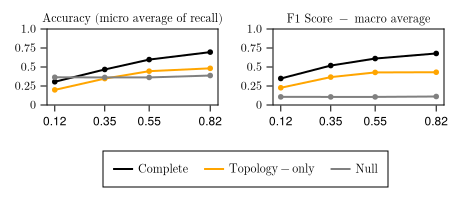

In [58]:
fig = Figure(resolution = (460,200),fontsize = fontsize_pub)

ax1 = Axis(fig[1:4,1:2],xgridvisible = false,ygridvisible = false,title = L"\text{Accuracy (micro average of recall)}")
ax2 = Axis(fig[1:4,3:4],xgridvisible = false,ygridvisible = false,title = L"\text{F1 Score - macro average}")

CairoMakie.lines!(ax1,axis_bins,total_accuracy_gt, color = :black,label = L"\text{Complete}",linewidth = 2.)
CairoMakie.lines!(ax1,axis_bins,total_accuracy_tt, color = :orange,label = L"\text{Topology-only}",linewidth = 2.)
CairoMakie.lines!(ax1,axis_bins,total_accuracy_null, color = :grey,label = L"\text{Null}",linewidth = 2.)

CairoMakie.scatter!(ax1,axis_bins,total_accuracy_gt, color = :black,markersize = 8.)
CairoMakie.scatter!(ax1,axis_bins,total_accuracy_tt, color = :orange,markersize = 8.)
CairoMakie.scatter!(ax1,axis_bins,total_accuracy_null, color = :grey,markersize = 8.)

CairoMakie.lines!(ax2,axis_bins,f1_macro_gt,color = :black,linewidth = 2.)
CairoMakie.lines!(ax2,axis_bins,f1_macro_tt,color = :orange,linewidth = 2.)
CairoMakie.lines!(ax2,axis_bins,f1_macro_null,color = :grey,linewidth = 2.)

CairoMakie.scatter!(ax2,axis_bins,f1_macro_gt,color = :black,markersize = 8.)
CairoMakie.scatter!(ax2,axis_bins,f1_macro_tt,color = :orange,markersize = 8.)
CairoMakie.scatter!(ax2,axis_bins,f1_macro_null,color = :grey,markersize = 8.)

ax1.xticks = (axis_bins, string.(round.(axis_bins,digits =2)))
ax1.yticks = ([0,0.25,0.5,0.75,1.], [L"0",L"0.25",L"0.5",L"0.75",L"1.0"])

ax2.xticks = (axis_bins, string.(round.(axis_bins,digits =2)))
ax2.yticks = ([0,0.25,0.5,0.75,1.], [L"0",L"0.25",L"0.5",L"0.75",L"1.0"])

fig[5, 1:4] = Legend(fig, ax1,orientation = :horizontal)

CairoMakie.ylims!(ax1,0.,1.)
CairoMakie.ylims!(ax2,0.,1.)

cond_save(plotsdirx(plot_save_dir_supp,"NullPerformance.pdf"),fig,save_figs)

fig

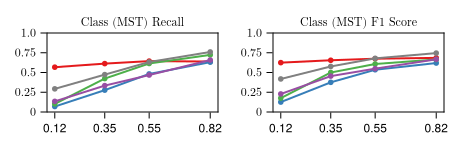

In [59]:
fig = Figure(resolution = (460,150),fontsize = fontsize_pub)

ax1 = Axis(fig[1:4,1:2],xgridvisible = false,ygridvisible = false,title = L"\text{Class (MST) Recall}")
ax2 = Axis(fig[1:4,3:4],xgridvisible = false,ygridvisible = false,title = L"\text{Class (MST) F1 Score}")

for n in 1:top_n+1

    l1 = CairoMakie.lines!(ax1,axis_bins,class_recall_gt[n,:],color = predict_colors[n],linewidth = 2.)
    l1 = CairoMakie.lines!(ax2,axis_bins,f1_class_gt[n,:],color = predict_colors[n],linewidth = 2.)

    CairoMakie.scatter!(ax1,axis_bins,class_recall_gt[n,:],color = predict_colors[n],markersize = 8.)
    CairoMakie.scatter!(ax2,axis_bins,f1_class_gt[n,:],color = predict_colors[n],markersize = 8.)

end

ax1.xticks = (axis_bins, string.(round.(axis_bins,digits =2)))
ax1.yticks = ([0,0.25,0.5,0.75,1.], [L"0",L"0.25",L"0.5",L"0.75",L"1.0"])

ax2.xticks = (axis_bins, string.(round.(axis_bins,digits =2)))
ax2.yticks = ([0,0.25,0.5,0.75,1.], [L"0",L"0.25",L"0.5",L"0.75",L"1.0"])


CairoMakie.ylims!(ax1,0.,1.)
CairoMakie.ylims!(ax2,0.,1.)

cond_save(plotsdirx(plot_save_dir_supp,"MSTPerformance.pdf"),fig,save_figs)

fig

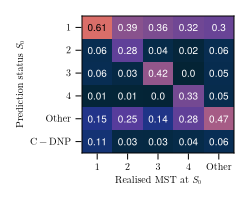

In [60]:
fig = Figure(resolution = (250,200),fontsize = 10)

ax1 = Axis(fig[1:4,1:2],xgridvisible = false,ygridvisible = false,xlabel = L"\text{Realised MST at } S_0",ylabel = L"\text{Prediction status } S_0",yreversed = true)

confmat = create_confusion_matrices_class(pred_scores_gt,2,true)

hm = CairoMakie.heatmap!(ax1, confmat |> transpose,colorrange = (0.,1.),colormap = :thermal)


text!(ax1,
    [x == string(NaN) ? "" : x for x in vec(string.(round.(confmat,digits = 2)))],
    position = [Point2f(x, y) for x in 1:5  for y in 1:6],
    align = (:center, :center),
    color = ifelse.(confmat .< 0.5, :white, :black),
    fontsize = 10,
    )


ax1.xticks = (1:5,[L"1",L"2",L"3",L"4",L"\text{Other}",])
ax1.yticks = (1:6,[L"1",L"2",L"3",L"4",L"\text{Other}",L"\text{C-DNP}"])

cond_save(plotsdirx(plot_save_dir_supp,"ConfusionBins.pdf"),fig,save_figs)

fig

In [61]:
predict_mst = [vertex_top_map[id] for id in predict_id];
predict_mst_complexity = [sum(abs.(v)) for v in predict_mst];

Retrieve target mutants for contingency analysis

In [62]:
mut_n = 1
n_weight = 2

all_target_mutants = []
all_target_networks = []
all_target_prob = []
all_target_ent_deltas = []
all_target_max_ent = []

for n in 1:top_n+1

    if n == top_n+1
        sample = filter(tr->tr.gt_label_predictions[mut_n+1] == -1 ,trajectories_p)
    else
        sample = filter(tr->tr.gt_label_predictions[mut_n+1] == sorted_uep[n],trajectories_p)
    end

    sample_entropy_deltas = map(tr->tr.gt_label_entropies[2:end] .- tr.gt_label_entropies[1:end-1],sample);
    sample_top_edits_deltas = map(tr->tr.weight_edits[2:end] .- tr.weight_edits[1:end-1],sample)

    sample_start_networks = map(tr->tr.geno_traj[mut_n],sample)
    sample_resultant_networks = map(tr->tr.geno_traj[mut_n+1],sample)

    sample_mutations = map(tr->tr.mutant_info[mut_n],sample)

    sample_probabilities = map(tr->tr.gt_label_probabilities[mut_n+1,:],sample)

    sample_top_edits_delta_select = map(x->x[mut_n],sample_top_edits_deltas);

    sample_entropy_delta_select = map(x->x[mut_n],sample_entropy_deltas);

    max_ent_delta = minimum(sample_entropy_delta_select[findall(sample_top_edits_delta_select .== n_weight)])

    target_mutant_id = findall(sample_top_edits_delta_select .== n_weight) ∩ findall(sample_entropy_delta_select .== max_ent_delta)

    target_mutant = sample_mutations[target_mutant_id[1]]

    target_prob = sample_probabilities[target_mutant_id[1]]

    push!(all_target_mutants,target_mutant)
    push!(all_target_prob,target_prob)
    push!(all_target_max_ent,max_ent_delta)
    push!(all_target_ent_deltas,sample_entropy_delta_select[findall(sample_top_edits_delta_select .== n_weight)])

    start_network = sample_start_networks[target_mutant_id[1]]
    resultant_network = sample_resultant_networks[target_mutant_id[1]]

    push!(all_target_networks,(start_network,resultant_network))
end

Load contingency experiments 

In [63]:
contingency_data = Dict()

all_top_msn = []

all_top_msn_counts = []

vim_trajectories = []
vim_vertex_top_map = []

for n in 1:top_n+1

    data_con = load(datadirx("exp_pro/DeNovoStripe/Contingencies/RE_Minimal_Inhibiting_DN_Contingent_" * string(n) * "_RawData.jld2"));

    conv_con = copy(data_con["converged"]);

    print("MST: " * string(n) * " - " * string(sum(conv_con)/length(conv_con)))
    print("\n")
    
    nconv_con = sum(conv_con)

    fs_mss_con =  map(list_mss->select_minimal_topologies(list_mss),data_con["min_fs_networks"])
    ls_mss_con =  map(list_mss->select_minimal_topologies(list_mss),data_con["min_end_networks"]);

    trajectories_con = map(k->Trajectory(k,data_con["geno_traj"][conv_con][k],data_con["fitness_traj"][conv_con][k],data_con["wait_times"][conv_con][k] .+ 1,data_con["mut_choices"][conv_con][k],data_con["mut_type"][conv_con][k],data_con["mut_sizes"][conv_con][k],weight_names),1:nconv_con);

    for (nt,tr) in enumerate(trajectories_con)
        assign_minimal_subgraphs!(tr,fs_mss_con[nt],ls_mss_con[nt])
    end

    inc_metagraph_con, vertex_top_map_con,top_vertex_map_con,vertex_complexity_map_con,inclusion_matrix_con = create_inclusion_metagraph(trajectories_con);

    minimal_motif_id_con = findall(indegree(inc_metagraph_con) .== 0);

    minimal_motifs_con = reduce(hcat,[vertex_top_map_con[vertex_id] for vertex_id in minimal_motif_id_con]);

    for tr in trajectories_con
        tr.inc_metagraph_vertices = create_label_H0(tr,top_vertex_map,predict_id,predict_mst)
        tr.inc_metagraph_parents = create_label_H0_parent(tr,top_vertex_map,predict_id,predict_mst,predict_mst_complexity)
    end

    push!(vim_trajectories,trajectories_con)
    push!(vim_vertex_top_map,vertex_top_map_con)

end

contingency_data["Double"] = [all_target_networks,all_target_prob,vim_trajectories,all_target_ent_deltas,all_target_max_ent,all_target_mutants];

MST: 1 - 1.0


MST: 2 - 0.964


MST: 3 - 0.6882


MST: 4 - 0.9856


MST: 5 - 0.732


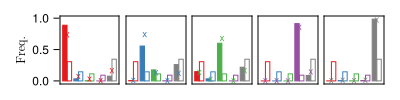

In [64]:
fig = CairoMakie.Figure(resolution = (400,100),fontsize = 12.)

create_contingency_accuracy_summary!(fig,contingency_data["Double"][3],contingency_data["Double"][2],null_H0_dist,top_n,predict_label_to_vertex,predict_colors)

fig